# Sprint セグメンテーション2

## 1.このSprintについて

### Sprintの目的
- セグメンテーションの精度を向上させる

### どのように学ぶか
- Kaggleコンペティションの情報を参考にセグメンテーションの精度を向上させます。

## 2.セグメンテーションの精度向上

前回に引き続きTGS Salt Identification Challengのデータセットの学習・推定を行います。

<a href="https://www.kaggle.com/c/tgs-salt-identification-challenge">
TGS Salt Identification Challenge | Kaggle
</a>

## 【準備】


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%cd '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint19/'

/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint19


## 【問題1】コードレビュー
転移学習を使用してセグメンテーションの精度を改善したコードを提示するので、レビューを行ってください。


《視点例》

- 前回使用した実装とはどのように違うのか
- 転移学習をどのように行っているか

### 通常のU-Net

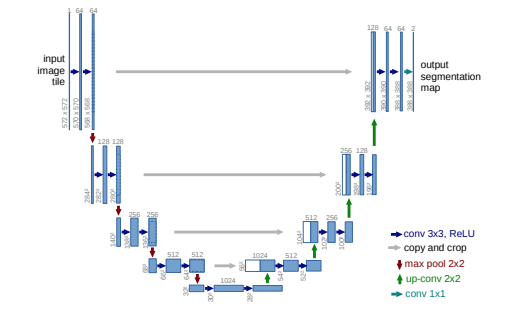

In [12]:
from IPython.display import Image
Image('./img/u_net1.png')

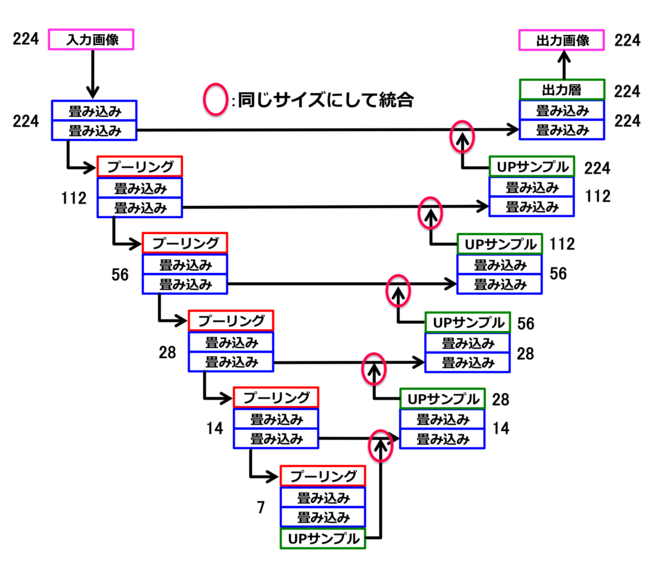

In [13]:
Image('./img/u_net2.png')

### Model architecture tuning & score optimization

- 前回のSprintではU-Netの構造をそのまま利用
- 今回はEncorder部分をResNetとし、center_blockを挟んで、U-Net構造でDecorderを定義している

※ResNetを呼び出す際、include_top=Falseとすることで最後の出力層を除外している。<br>base_model = ResNet50(input_shape=input_size, include_top=False)



```
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('conv1').output # activation_1
    encoder2 = base_model.get_layer('res2c_branch2c').output # activation_10
    encoder3 = base_model.get_layer('res3d_branch2c').output # activation_22
    encoder4 = base_model.get_layer('res4f_branch2c').output # activation_40
    encoder5 = base_model.get_layer('res5c_branch2c').output # activation_40

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model
```

#### ResNetの構造

```
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 112, 112, 64) 0           conv1_bn[0][0]                   
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_relu[0][0]                 
__________________________________________________________________________________________________
pool1_pool (MaxPooling2D)       (None, 56, 56, 64)   0           pool1_pad[0][0]                  
__________________________________________________________________________________________________
conv2_block1_1_conv (Conv2D)    (None, 56, 56, 64)   4160        pool1_pool[0][0]                 
__________________________________________________________________________________________________
conv2_block1_1_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv2_block1_1_relu (Activation (None, 56, 56, 64)   0           conv2_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv2_block1_2_conv (Conv2D)    (None, 56, 56, 64)   36928       conv2_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv2_block1_2_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv2_block1_2_relu (Activation (None, 56, 56, 64)   0           conv2_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv2_block1_0_conv (Conv2D)    (None, 56, 56, 256)  16640       pool1_pool[0][0]                 
__________________________________________________________________________________________________
conv2_block1_3_conv (Conv2D)    (None, 56, 56, 256)  16640       conv2_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv2_block1_0_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv2_block1_3_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv2_block1_add (Add)          (None, 56, 56, 256)  0           conv2_block1_0_bn[0][0]          
                                                                 conv2_block1_3_bn[0][0]          
__________________________________________________________________________________________________
conv2_block1_out (Activation)   (None, 56, 56, 256)  0           conv2_block1_add[0][0]           
__________________________________________________________________________________________________
conv2_block2_1_conv (Conv2D)    (None, 56, 56, 64)   16448       conv2_block1_out[0][0]           
__________________________________________________________________________________________________
conv2_block2_1_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv2_block2_1_relu (Activation (None, 56, 56, 64)   0           conv2_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv2_block2_2_conv (Conv2D)    (None, 56, 56, 64)   36928       conv2_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv2_block2_2_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv2_block2_2_relu (Activation (None, 56, 56, 64)   0           conv2_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv2_block2_3_conv (Conv2D)    (None, 56, 56, 256)  16640       conv2_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv2_block2_3_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv2_block2_add (Add)          (None, 56, 56, 256)  0           conv2_block1_out[0][0]           
                                                                 conv2_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv2_block2_out (Activation)   (None, 56, 56, 256)  0           conv2_block2_add[0][0]           
__________________________________________________________________________________________________
conv2_block3_1_conv (Conv2D)    (None, 56, 56, 64)   16448       conv2_block2_out[0][0]           
__________________________________________________________________________________________________
conv2_block3_1_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv2_block3_1_relu (Activation (None, 56, 56, 64)   0           conv2_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv2_block3_2_conv (Conv2D)    (None, 56, 56, 64)   36928       conv2_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv2_block3_2_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block3_2_conv[0][0]        
__________________________________________________________________________________________________
conv2_block3_2_relu (Activation (None, 56, 56, 64)   0           conv2_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv2_block3_3_conv (Conv2D)    (None, 56, 56, 256)  16640       conv2_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv2_block3_3_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv2_block3_add (Add)          (None, 56, 56, 256)  0           conv2_block2_out[0][0]           
                                                                 conv2_block3_3_bn[0][0]          
__________________________________________________________________________________________________
conv2_block3_out (Activation)   (None, 56, 56, 256)  0           conv2_block3_add[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_conv (Conv2D)    (None, 28, 28, 128)  32896       conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_1_relu (Activation (None, 28, 28, 128)  0           conv3_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block1_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_2_relu (Activation (None, 28, 28, 128)  0           conv3_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_0_conv (Conv2D)    (None, 28, 28, 512)  131584      conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block1_0_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_add (Add)          (None, 28, 28, 512)  0           conv3_block1_0_bn[0][0]          
                                                                 conv3_block1_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_out (Activation)   (None, 28, 28, 512)  0           conv3_block1_add[0][0]           
__________________________________________________________________________________________________
conv3_block2_1_conv (Conv2D)    (None, 28, 28, 128)  65664       conv3_block1_out[0][0]           
__________________________________________________________________________________________________
conv3_block2_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block2_1_relu (Activation (None, 28, 28, 128)  0           conv3_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block2_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block2_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block2_2_relu (Activation (None, 28, 28, 128)  0           conv3_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block2_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block2_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block2_add (Add)          (None, 28, 28, 512)  0           conv3_block1_out[0][0]           
                                                                 conv3_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block2_out (Activation)   (None, 28, 28, 512)  0           conv3_block2_add[0][0]           
__________________________________________________________________________________________________
conv3_block3_1_conv (Conv2D)    (None, 28, 28, 128)  65664       conv3_block2_out[0][0]           
__________________________________________________________________________________________________
conv3_block3_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block3_1_relu (Activation (None, 28, 28, 128)  0           conv3_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block3_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block3_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block3_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block3_2_relu (Activation (None, 28, 28, 128)  0           conv3_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block3_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block3_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block3_add (Add)          (None, 28, 28, 512)  0           conv3_block2_out[0][0]           
                                                                 conv3_block3_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block3_out (Activation)   (None, 28, 28, 512)  0           conv3_block3_add[0][0]           
__________________________________________________________________________________________________
conv3_block4_1_conv (Conv2D)    (None, 28, 28, 128)  65664       conv3_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block4_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block4_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, 28, 28, 128)  0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_relu (Activation (None, 28, 28, 128)  0           conv3_block4_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block4_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_add (Add)          (None, 28, 28, 512)  0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_0_conv (Conv2D)    (None, 14, 14, 1024) 525312      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_0_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_add (Add)          (None, 14, 14, 1024) 0           conv4_block1_0_bn[0][0]          
                                                                 conv4_block1_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_out (Activation)   (None, 14, 14, 1024) 0           conv4_block1_add[0][0]           
__________________________________________________________________________________________________
conv4_block2_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block1_out[0][0]           
__________________________________________________________________________________________________
conv4_block2_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_1_relu (Activation (None, 14, 14, 256)  0           conv4_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_2_relu (Activation (None, 14, 14, 256)  0           conv4_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_add (Add)          (None, 14, 14, 1024) 0           conv4_block1_out[0][0]           
                                                                 conv4_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_out (Activation)   (None, 14, 14, 1024) 0           conv4_block2_add[0][0]           
__________________________________________________________________________________________________
conv4_block3_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block2_out[0][0]           
__________________________________________________________________________________________________
conv4_block3_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block3_1_relu (Activation (None, 14, 14, 256)  0           conv4_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block3_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block3_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block3_2_relu (Activation (None, 14, 14, 256)  0           conv4_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block3_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block3_add (Add)          (None, 14, 14, 1024) 0           conv4_block2_out[0][0]           
                                                                 conv4_block3_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_out (Activation)   (None, 14, 14, 1024) 0           conv4_block3_add[0][0]           
__________________________________________________________________________________________________
conv4_block4_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block3_out[0][0]           
__________________________________________________________________________________________________
conv4_block4_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block4_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_1_relu (Activation (None, 14, 14, 256)  0           conv4_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block4_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_2_relu (Activation (None, 14, 14, 256)  0           conv4_block4_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block4_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block4_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_add (Add)          (None, 14, 14, 1024) 0           conv4_block3_out[0][0]           
                                                                 conv4_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_out (Activation)   (None, 14, 14, 1024) 0           conv4_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block5_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block5_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block5_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_1_relu (Activation (None, 14, 14, 256)  0           conv4_block5_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block5_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block5_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block5_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block5_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_2_relu (Activation (None, 14, 14, 256)  0           conv4_block5_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block5_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block5_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block5_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block5_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_add (Add)          (None, 14, 14, 1024) 0           conv4_block4_out[0][0]           
                                                                 conv4_block5_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block5_out (Activation)   (None, 14, 14, 1024) 0           conv4_block5_add[0][0]           
__________________________________________________________________________________________________
conv4_block6_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block5_out[0][0]           
__________________________________________________________________________________________________
conv4_block6_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block6_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block6_1_relu (Activation (None, 14, 14, 256)  0           conv4_block6_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block6_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block6_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block6_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block6_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block6_2_relu (Activation (None, 14, 14, 256)  0           conv4_block6_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block6_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block6_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block6_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block6_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block6_add (Add)          (None, 14, 14, 1024) 0           conv4_block5_out[0][0]           
                                                                 conv4_block6_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block6_out (Activation)   (None, 14, 14, 1024) 0           conv4_block6_add[0][0]           
__________________________________________________________________________________________________
conv5_block1_1_conv (Conv2D)    (None, 7, 7, 512)    524800      conv4_block6_out[0][0]           
__________________________________________________________________________________________________
conv5_block1_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_1_relu (Activation (None, 7, 7, 512)    0           conv5_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block1_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block1_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_2_relu (Activation (None, 7, 7, 512)    0           conv5_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv5_block1_0_conv (Conv2D)    (None, 7, 7, 2048)   2099200     conv4_block6_out[0][0]           
__________________________________________________________________________________________________
conv5_block1_3_conv (Conv2D)    (None, 7, 7, 2048)   1050624     conv5_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv5_block1_0_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_3_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_add (Add)          (None, 7, 7, 2048)   0           conv5_block1_0_bn[0][0]          
                                                                 conv5_block1_3_bn[0][0]          
__________________________________________________________________________________________________
conv5_block1_out (Activation)   (None, 7, 7, 2048)   0           conv5_block1_add[0][0]           
__________________________________________________________________________________________________
conv5_block2_1_conv (Conv2D)    (None, 7, 7, 512)    1049088     conv5_block1_out[0][0]           
__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_1_relu (Activation (None, 7, 7, 512)    0           conv5_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_relu (Activation (None, 7, 7, 512)    0           conv5_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_3_conv (Conv2D)    (None, 7, 7, 2048)   1050624     conv5_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_3_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_add (Add)          (None, 7, 7, 2048)   0           conv5_block1_out[0][0]           
                                                                 conv5_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_out (Activation)   (None, 7, 7, 2048)   0           conv5_block2_add[0][0]           
__________________________________________________________________________________________________
conv5_block3_1_conv (Conv2D)    (None, 7, 7, 512)    1049088     conv5_block2_out[0][0]           
__________________________________________________________________________________________________
conv5_block3_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block3_1_relu (Activation (None, 7, 7, 512)    0           conv5_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block3_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block3_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block3_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block3_2_relu (Activation (None, 7, 7, 512)    0           conv5_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv5_block3_3_conv (Conv2D)    (None, 7, 7, 2048)   1050624     conv5_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv5_block3_3_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block3_add (Add)          (None, 7, 7, 2048)   0           conv5_block2_out[0][0]           
                                                                 conv5_block3_3_bn[0][0]          
__________________________________________________________________________________________________
conv5_block3_out (Activation)   (None, 7, 7, 2048)   0           conv5_block3_add[0][0]           
==================================================================================================
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
__________________________________________________________________________________________________
```

## 【問題2】コードの書き換え

エンコーダーにResNetが使用されていたコードをVGGに変更してください。

- <a href="https://github.com/obata01/diveintocode-ml/tree/master/kadai/Sprint20/models_pretrained_and_more.ipynb">実行したコードはこちらにまとめました</a>

- <a href="https://github.com/obata01/diveintocode-ml/tree/master/kadai/Sprint20/VGGandU-Net2.pdf">今回作成したVGG16+U-Netの構成詳細はこちらにまとめました</a>

## 【問題3】学習・推定
ResNetとVGG双方のコードで学習・推定を行い、結果を比較してください。

### ResNet

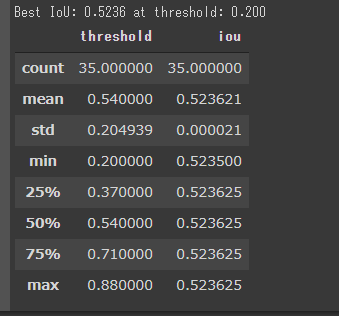

In [19]:
Image('./img/resnet1.png')

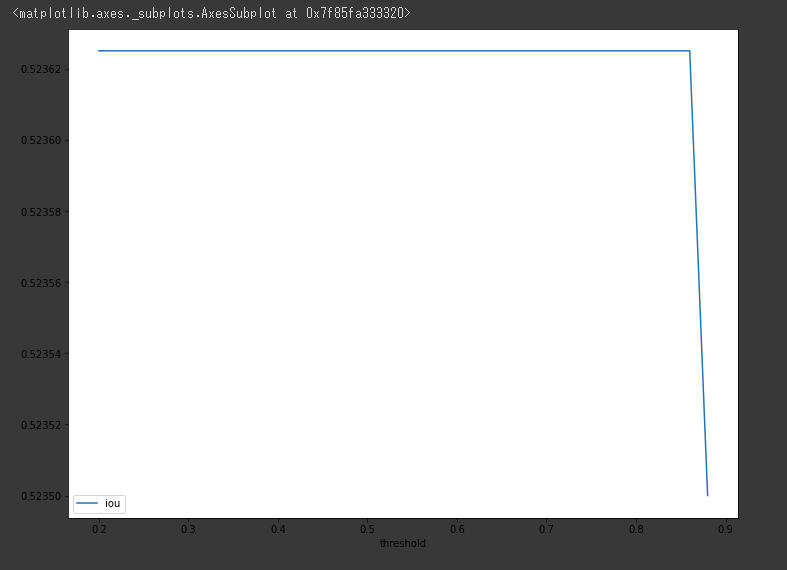

In [21]:
# 表示が変？何か間違えた？
Image('./img/resnet2.png')

### VGG-16

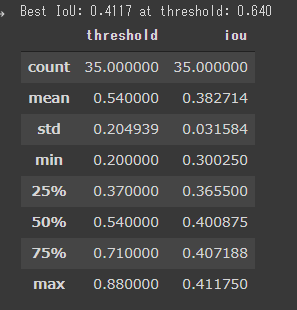

In [17]:
Image('./img/vgg1.png')

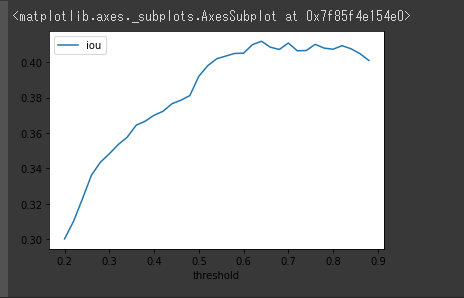

In [18]:
Image('./img/vgg2.png')

VGG16の実行内容は下記

```
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_conv1 (Conv2D)           (None, 112, 112, 128 73856       block1_pool[0][0]                
__________________________________________________________________________________________________
block2_conv2 (Conv2D)           (None, 112, 112, 128 147584      block2_conv1[0][0]               
__________________________________________________________________________________________________
block2_pool (MaxPooling2D)      (None, 56, 56, 128)  0           block2_conv2[0][0]               
__________________________________________________________________________________________________
block3_conv1 (Conv2D)           (None, 56, 56, 256)  295168      block2_pool[0][0]                
__________________________________________________________________________________________________
block3_conv2 (Conv2D)           (None, 56, 56, 256)  590080      block3_conv1[0][0]               
__________________________________________________________________________________________________
block3_conv3 (Conv2D)           (None, 56, 56, 256)  590080      block3_conv2[0][0]               
__________________________________________________________________________________________________
block3_pool (MaxPooling2D)      (None, 28, 28, 256)  0           block3_conv3[0][0]               
__________________________________________________________________________________________________
block4_conv1 (Conv2D)           (None, 28, 28, 512)  1180160     block3_pool[0][0]                
__________________________________________________________________________________________________
block4_conv2 (Conv2D)           (None, 28, 28, 512)  2359808     block4_conv1[0][0]               
__________________________________________________________________________________________________
block4_conv3 (Conv2D)           (None, 28, 28, 512)  2359808     block4_conv2[0][0]               
__________________________________________________________________________________________________
block4_pool (MaxPooling2D)      (None, 14, 14, 512)  0           block4_conv3[0][0]               
__________________________________________________________________________________________________
block5_conv1 (Conv2D)           (None, 14, 14, 512)  2359808     block4_pool[0][0]                
__________________________________________________________________________________________________
block5_conv2 (Conv2D)           (None, 14, 14, 512)  2359808     block5_conv1[0][0]               
__________________________________________________________________________________________________
block5_conv3 (Conv2D)           (None, 14, 14, 512)  2359808     block5_conv2[0][0]               
__________________________________________________________________________________________________
center_conv1 (Conv2D)           (None, 14, 14, 512)  2359808     block5_conv3[0][0]               
__________________________________________________________________________________________________
center_bn1 (BatchNormalization) (None, 14, 14, 512)  2048        center_conv1[0][0]               
__________________________________________________________________________________________________
center_activation1 (PReLU)      (None, 14, 14, 512)  100352      center_bn1[0][0]                 
__________________________________________________________________________________________________
dropout (Dropout)               (None, 14, 14, 512)  0           center_activation1[0][0]         
__________________________________________________________________________________________________
center_conv2 (Conv2D)           (None, 14, 14, 256)  1179904     dropout[0][0]                    
__________________________________________________________________________________________________
center_bn2 (BatchNormalization) (None, 14, 14, 256)  1024        center_conv2[0][0]               
__________________________________________________________________________________________________
center_activation2 (PReLU)      (None, 14, 14, 256)  50176       center_bn2[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 14, 14, 256)  0           center_activation2[0][0]         
__________________________________________________________________________________________________
center_conv3 (Conv2D)           (None, 14, 14, 512)  1180160     dropout_1[0][0]                  
__________________________________________________________________________________________________
center_bn3 (BatchNormalization) (None, 14, 14, 512)  2048        center_conv3[0][0]               
__________________________________________________________________________________________________
center_activation3 (PReLU)      (None, 14, 14, 512)  100352      center_bn3[0][0]                 
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 14, 14, 512)  0           center_activation3[0][0]         
__________________________________________________________________________________________________
add (Add)                       (None, 14, 14, 512)  0           dropout[0][0]                    
                                                                 dropout_2[0][0]                  
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 14, 14, 1024) 0           add[0][0]                        
                                                                 block5_conv3[0][0]               
__________________________________________________________________________________________________
decoder4_conv1 (Conv2D)         (None, 14, 14, 256)  2359552     concatenate[0][0]                
__________________________________________________________________________________________________
decoder4_bn1 (BatchNormalizatio (None, 14, 14, 256)  1024        decoder4_conv1[0][0]             
__________________________________________________________________________________________________
decoder4_activation1 (PReLU)    (None, 14, 14, 256)  50176       decoder4_bn1[0][0]               
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 14, 14, 256)  0           decoder4_activation1[0][0]       
__________________________________________________________________________________________________
decoder4_conv2 (Conv2D)         (None, 14, 14, 128)  295040      dropout_3[0][0]                  
__________________________________________________________________________________________________
decoder4_bn2 (BatchNormalizatio (None, 14, 14, 128)  512         decoder4_conv2[0][0]             
__________________________________________________________________________________________________
decoder4_activation2 (PReLU)    (None, 14, 14, 128)  25088       decoder4_bn2[0][0]               
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 14, 14, 128)  0           decoder4_activation2[0][0]       
__________________________________________________________________________________________________
decoder4_conv3 (Conv2D)         (None, 14, 14, 256)  295168      dropout_4[0][0]                  
__________________________________________________________________________________________________
decoder4_bn3 (BatchNormalizatio (None, 14, 14, 256)  1024        decoder4_conv3[0][0]             
__________________________________________________________________________________________________
decoder4_activation3 (PReLU)    (None, 14, 14, 256)  50176       decoder4_bn3[0][0]               
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 14, 14, 256)  0           decoder4_activation3[0][0]       
__________________________________________________________________________________________________
add_1 (Add)                     (None, 14, 14, 256)  0           dropout_3[0][0]                  
                                                                 dropout_5[0][0]                  
__________________________________________________________________________________________________
up_sampling2d (UpSampling2D)    (None, 28, 28, 256)  0           add_1[0][0]                      
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 28, 28, 768)  0           up_sampling2d[0][0]              
                                                                 block4_conv3[0][0]               
__________________________________________________________________________________________________
decoder3_conv1 (Conv2D)         (None, 28, 28, 128)  884864      concatenate_1[0][0]              
__________________________________________________________________________________________________
decoder3_bn1 (BatchNormalizatio (None, 28, 28, 128)  512         decoder3_conv1[0][0]             
__________________________________________________________________________________________________
decoder3_activation1 (PReLU)    (None, 28, 28, 128)  100352      decoder3_bn1[0][0]               
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 28, 28, 128)  0           decoder3_activation1[0][0]       
__________________________________________________________________________________________________
decoder3_conv2 (Conv2D)         (None, 28, 28, 64)   73792       dropout_6[0][0]                  
__________________________________________________________________________________________________
decoder3_bn2 (BatchNormalizatio (None, 28, 28, 64)   256         decoder3_conv2[0][0]             
__________________________________________________________________________________________________
decoder3_activation2 (PReLU)    (None, 28, 28, 64)   50176       decoder3_bn2[0][0]               
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 28, 28, 64)   0           decoder3_activation2[0][0]       
__________________________________________________________________________________________________
decoder3_conv3 (Conv2D)         (None, 28, 28, 128)  73856       dropout_7[0][0]                  
__________________________________________________________________________________________________
decoder3_bn3 (BatchNormalizatio (None, 28, 28, 128)  512         decoder3_conv3[0][0]             
__________________________________________________________________________________________________
decoder3_activation3 (PReLU)    (None, 28, 28, 128)  100352      decoder3_bn3[0][0]               
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 28, 28, 128)  0           decoder3_activation3[0][0]       
__________________________________________________________________________________________________
add_2 (Add)                     (None, 28, 28, 128)  0           dropout_6[0][0]                  
                                                                 dropout_8[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 56, 56, 128)  0           add_2[0][0]                      
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 56, 56, 384)  0           up_sampling2d_1[0][0]            
                                                                 block3_conv3[0][0]               
__________________________________________________________________________________________________
decoder2_conv1 (Conv2D)         (None, 56, 56, 64)   221248      concatenate_2[0][0]              
__________________________________________________________________________________________________
decoder2_bn1 (BatchNormalizatio (None, 56, 56, 64)   256         decoder2_conv1[0][0]             
__________________________________________________________________________________________________
decoder2_activation1 (PReLU)    (None, 56, 56, 64)   200704      decoder2_bn1[0][0]               
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 56, 56, 64)   0           decoder2_activation1[0][0]       
__________________________________________________________________________________________________
decoder2_conv2 (Conv2D)         (None, 56, 56, 32)   18464       dropout_9[0][0]                  
__________________________________________________________________________________________________
decoder2_bn2 (BatchNormalizatio (None, 56, 56, 32)   128         decoder2_conv2[0][0]             
__________________________________________________________________________________________________
decoder2_activation2 (PReLU)    (None, 56, 56, 32)   100352      decoder2_bn2[0][0]               
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 56, 56, 32)   0           decoder2_activation2[0][0]       
__________________________________________________________________________________________________
decoder2_conv3 (Conv2D)         (None, 56, 56, 64)   18496       dropout_10[0][0]                 
__________________________________________________________________________________________________
decoder2_bn3 (BatchNormalizatio (None, 56, 56, 64)   256         decoder2_conv3[0][0]             
__________________________________________________________________________________________________
decoder2_activation3 (PReLU)    (None, 56, 56, 64)   200704      decoder2_bn3[0][0]               
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 56, 56, 64)   0           decoder2_activation3[0][0]       
__________________________________________________________________________________________________
add_3 (Add)                     (None, 56, 56, 64)   0           dropout_9[0][0]                  
                                                                 dropout_11[0][0]                 
__________________________________________________________________________________________________
up_sampling2d_2 (UpSampling2D)  (None, 112, 112, 64) 0           add_3[0][0]                      
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 112, 112, 192 0           up_sampling2d_2[0][0]            
                                                                 block2_conv2[0][0]               
__________________________________________________________________________________________________
decoder1_conv1 (Conv2D)         (None, 112, 112, 64) 110656      concatenate_3[0][0]              
__________________________________________________________________________________________________
decoder1_bn1 (BatchNormalizatio (None, 112, 112, 64) 256         decoder1_conv1[0][0]             
__________________________________________________________________________________________________
decoder1_activation1 (PReLU)    (None, 112, 112, 64) 802816      decoder1_bn1[0][0]               
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 112, 112, 64) 0           decoder1_activation1[0][0]       
__________________________________________________________________________________________________
decoder1_conv2 (Conv2D)         (None, 112, 112, 32) 18464       dropout_12[0][0]                 
__________________________________________________________________________________________________
decoder1_bn2 (BatchNormalizatio (None, 112, 112, 32) 128         decoder1_conv2[0][0]             
__________________________________________________________________________________________________
decoder1_activation2 (PReLU)    (None, 112, 112, 32) 401408      decoder1_bn2[0][0]               
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 112, 112, 32) 0           decoder1_activation2[0][0]       
__________________________________________________________________________________________________
decoder1_conv3 (Conv2D)         (None, 112, 112, 64) 18496       dropout_13[0][0]                 
__________________________________________________________________________________________________
decoder1_bn3 (BatchNormalizatio (None, 112, 112, 64) 256         decoder1_conv3[0][0]             
__________________________________________________________________________________________________
decoder1_activation3 (PReLU)    (None, 112, 112, 64) 802816      decoder1_bn3[0][0]               
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 112, 112, 64) 0           decoder1_activation3[0][0]       
__________________________________________________________________________________________________
add_4 (Add)                     (None, 112, 112, 64) 0           dropout_12[0][0]                 
                                                                 dropout_14[0][0]                 
__________________________________________________________________________________________________
up_sampling2d_3 (UpSampling2D)  (None, 224, 224, 64) 0           add_4[0][0]                      
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 224, 224, 128 0           up_sampling2d_3[0][0]            
                                                                 block1_conv2[0][0]               
__________________________________________________________________________________________________
decoder_output_conv1 (Conv2D)   (None, 224, 224, 32) 36896       concatenate_4[0][0]              
__________________________________________________________________________________________________
decoder_output_bn1 (BatchNormal (None, 224, 224, 32) 128         decoder_output_conv1[0][0]       
__________________________________________________________________________________________________
decoder_output_activation1 (PRe (None, 224, 224, 32) 1605632     decoder_output_bn1[0][0]         
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 224, 224, 32) 0           decoder_output_activation1[0][0] 
__________________________________________________________________________________________________
decoder_output_conv2 (Conv2D)   (None, 224, 224, 16) 4624        dropout_15[0][0]                 
__________________________________________________________________________________________________
decoder_output_bn2 (BatchNormal (None, 224, 224, 16) 64          decoder_output_conv2[0][0]       
__________________________________________________________________________________________________
decoder_output_activation2 (PRe (None, 224, 224, 16) 802816      decoder_output_bn2[0][0]         
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 224, 224, 16) 0           decoder_output_activation2[0][0] 
__________________________________________________________________________________________________
decoder_output_conv3 (Conv2D)   (None, 224, 224, 32) 4640        dropout_16[0][0]                 
__________________________________________________________________________________________________
decoder_output_bn3 (BatchNormal (None, 224, 224, 32) 128         decoder_output_conv3[0][0]       
__________________________________________________________________________________________________
decoder_output_activation3 (PRe (None, 224, 224, 32) 1605632     decoder_output_bn3[0][0]         
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 224, 224, 32) 0           decoder_output_activation3[0][0] 
__________________________________________________________________________________________________
add_5 (Add)                     (None, 224, 224, 32) 0           dropout_15[0][0]                 
                                                                 dropout_17[0][0]                 
__________________________________________________________________________________________________
prediction (Conv2D)             (None, 224, 224, 1)  33          add_5[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 1)  0           prediction[0][0]                 
==================================================================================================
Total params: 31,029,489
Trainable params: 31,024,209
Non-trainable params: 5,280
__________________________________________________________________________________________________
None
Train on 3200 samples, validate on 800 samples
Epoch 1/2
3184/3200 [============================>.] - ETA: 8s - loss: 0.9168 - my_iou_metric: 0.1670 
Epoch 00001: val_my_iou_metric improved from -inf to 0.19850, saving model to unet_resnet.h5
3200/3200 [==============================] - 1728s 540ms/sample - loss: 0.9153 - my_iou_metric: 0.1675 - val_loss: 0.9175 - val_my_iou_metric: 0.1985
Epoch 2/2
3184/3200 [============================>.] - ETA: 8s - loss: 0.7688 - my_iou_metric: 0.2494 
Epoch 00002: val_my_iou_metric improved from 0.19850 to 0.35750, saving model to unet_resnet.h5
3200/3200 [==============================] - 1687s 527ms/sample - loss: 0.7674 - my_iou_metric: 0.2499 - val_loss: 0.8966 - val_my_iou_metric: 0.3575
```